In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from pathlib import Path

# Configurar visualizaciones
plt.style.use('default')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (10, 6)

print("Setup completo para análisis multi-fuentes!")

Setup completo para análisis multi-fuentes!


In [2]:
# === CARGAR DATOS DE MÚLTIPLES FUENTES ===

# 1. Cargar datos de viajes desde Parquet (Dataset oficial completo NYC)
print("Cargando datos oficiales de NYC Taxi (dataset completo)...")
trips_url = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet"

# Cargar dataset oficial (~3M registros de enero 2023) # función para leer archivos .parquet (más eficiente que CSV)
trips = pd.read_parquet(trips_url, engine="fastparquet")

print(f"   Viajes cargados: {trips.shape[0]:,} filas, {trips.shape[1]} columnas")
print(f"   Columnas: {list(trips.columns)}")
print(f"   Período: {trips['tpep_pickup_datetime'].min()} a {trips['tpep_pickup_datetime'].max()}")
print(f"   Tamaño en memoria: {trips.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# 2. Cargar datos de zonas desde CSV (Dataset oficial completo)
print("\nCargando datos oficiales de zonas NYC...")
zones_url = "https://d37ci6vzurychx.cloudfront.net/misc/taxi+_zone_lookup.csv"
zones = pd.read_csv(zones_url)  # función estándar para archivos CSV

print(f"   Zonas cargadas: {zones.shape[0]} filas, {zones.shape[1]} columnas")
print(f"   Columnas: {list(zones.columns)}")
print(f"   Boroughs únicos: {zones['Borough'].unique()}")

# 3. Cargar calendario de eventos desde JSON 
print("\nCargando datos de calendario de eventos...")
calendar_url = "https://juanfkurucz.com/ucu-id/ut1/data/calendar.json"
calendar = pd.read_json(calendar_url)  # función para archivos JSON
calendar['date'] = pd.to_datetime(calendar['date']).dt.date  # convertir strings a fechas, luego extraer solo la fecha

print(f"   Eventos calendario: {calendar.shape[0]} filas")
print(f"   Columnas: {list(calendar.columns)}")

# 4. Mostrar primeras filas de cada dataset
print("\nVISTA PREVIA DE DATOS:")
print("\n--- TRIPS ---")
print(trips.head())  # método para mostrar primeras filas de un DataFrame
print("\n--- ZONES ---")
print(zones.head())  # mismo método para ver estructura de datos
print("\n--- CALENDAR ---")
print(calendar.head())  # revisar formato de los eventos

Cargando datos oficiales de NYC Taxi (dataset completo)...
   Viajes cargados: 3,066,766 filas, 19 columnas
   Columnas: ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee']
   Período: 2008-12-31 23:01:42 a 2023-02-01 00:56:53
   Tamaño en memoria: 565.6 MB

Cargando datos oficiales de zonas NYC...
   Zonas cargadas: 265 filas, 4 columnas
   Columnas: ['LocationID', 'Borough', 'Zone', 'service_zone']
   Boroughs únicos: ['EWR' 'Queens' 'Bronx' 'Manhattan' 'Staten Island' 'Brooklyn' 'Unknown'
 nan]

Cargando datos de calendario de eventos...
   Eventos calendario: 3 filas
   Columnas: ['date', 'name', 'special']

VISTA PREVIA DE DATOS:

--- TRIPS ---
   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_c

In [3]:
# === NORMALIZAR Y PREPARAR DATOS PARA JOINS ===

# 1. Estandarizar nombres de columnas
print("Normalizando nombres de columnas...")
trips.columns = trips.columns.str.lower()  # convertir todas las columnas a minúsculas
zones.columns = zones.columns.str.lower()  # misma transformación para consistencia

print(f"   Trips columnas: {list(trips.columns)}")
print(f"   Zones columnas: {list(zones.columns)}")

# 2. Crear columna de fecha para el join con calendario
trips['pickup_date'] = trips['tpep_pickup_datetime'].dt.date  # extraer solo la fecha (sin hora) de la columna datetime

print(f"   Columna pickup_date creada")
print(f"   Rango de fechas: {trips['pickup_date'].min()} a {trips['pickup_date'].max()}")

# 3. Verificar tipos de datos para joins
print("\nVERIFICACIÓN DE TIPOS PARA JOINS:")
print(f"   trips['pulocationid'] tipo: {trips['pulocationid'].dtype}")
print(f"   zones['locationid'] tipo: {zones['locationid'].dtype}")
print(f"   trips['pickup_date'] tipo: {type(trips['pickup_date'].iloc[0])}")
print(f"   calendar['date'] tipo: {type(calendar['date'].iloc[0])}")

# 4. Optimización para datasets grandes (~3M registros)
print("\nOPTIMIZACIÓN PARA DATASETS GRANDES:")
initial_memory = trips.memory_usage(deep=True).sum() / 1024**2
print(f"   Memoria inicial: {initial_memory:.1f} MB")

# Optimizar tipos de datos para 3+ millones de registros
print("   Optimizando tipos de datos para 3M+ registros...")

# Limpiar valores nulos antes de convertir tipos
print("   Limpiando valores nulos antes de optimización...")
trips['passenger_count'] = trips['passenger_count'].fillna(1)  # método para rellenar valores nulos con un valor específico
trips = trips.dropna(subset=['pulocationid', 'dolocationid'])  # eliminar filas críticas sin ubicación (necesarias para joins)

# Convertir tipos después de limpiar
trips['pulocationid'] = trips['pulocationid'].astype('int16')
trips['dolocationid'] = trips['dolocationid'].astype('int16') 
trips['passenger_count'] = trips['passenger_count'].astype('int8')
zones['locationid'] = zones['locationid'].astype('int16')

print(f"   Registros después de limpieza: {len(trips):,}")

optimized_memory = trips.memory_usage(deep=True).sum() / 1024**2
savings = ((initial_memory - optimized_memory) / initial_memory * 100)

print(f"   Memoria optimizada: {optimized_memory:.1f} MB")
print(f"   Ahorro de memoria: {savings:.1f}%")

# 5. Revisar datos faltantes antes de joins
print("\nDATOS FALTANTES ANTES DE JOINS:")
print("Trips (top 5 columnas con más nulos):")
trips_nulls = trips.isna().sum().sort_values(ascending=False).head()  # método para detectar valores nulos, sumar y ordenar
print(trips_nulls)

print("\nZones:")
zones_nulls = zones.isna().sum()  # revisar si hay valores faltantes en lookup table
print(zones_nulls)

print("\nCalendar:")
calendar_nulls = calendar.isna().sum()  # verificar integridad del calendario de eventos
print(calendar_nulls)

# Análisis de calidad de datos
print("\nANÁLISIS DE CALIDAD:")
total_trips = len(trips)
print(f"   Total de viajes: {total_trips:,}")
print(f"   Viajes sin pickup location: {trips['pulocationid'].isna().sum():,}")
print(f"   Viajes sin dropoff location: {trips['dolocationid'].isna().sum():,}")
print(f"   Viajes sin passenger_count: {trips['passenger_count'].isna().sum():,}")

# Estrategias de limpieza recomendadas
print("\nESTRATEGIAS DE LIMPIEZA:")
print("   Ubicaciones nulas: Eliminar (crítico para joins)")
print("   Passenger_count nulos: Rellenar con valor típico (1)")
print("   Tarifas nulas: Revisar caso por caso")

Normalizando nombres de columnas...
   Trips columnas: ['vendorid', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'ratecodeid', 'store_and_fwd_flag', 'pulocationid', 'dolocationid', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee']
   Zones columnas: ['locationid', 'borough', 'zone', 'service_zone']
   Columna pickup_date creada
   Rango de fechas: 2008-12-31 a 2023-02-01

VERIFICACIÓN DE TIPOS PARA JOINS:
   trips['pulocationid'] tipo: int64
   zones['locationid'] tipo: int64
   trips['pickup_date'] tipo: <class 'datetime.date'>
   calendar['date'] tipo: <class 'datetime.date'>

OPTIMIZACIÓN PARA DATASETS GRANDES:
   Memoria inicial: 682.6 MB
   Optimizando tipos de datos para 3M+ registros...
   Limpiando valores nulos antes de optimización...
   Registros después de limpieza: 3,066,766
   Memoria optimizada: 627.0 MB
   Ahorro de memor

In [4]:
#Eliminar los datos nulos (71000 de 3000000 es razonable)
trips = trips.dropna()
print(f"Registros en trips: {len(trips)}")

# Rellenar valores nulos en las columnas de zones con 'Desconocido'
zones['borough'] = zones['borough'].fillna('Desconocido')
zones['zone'] = zones['zone'].fillna('Desconocido')
zones['service_zone'] = zones['service_zone'].fillna('Desconocido')

Registros en trips: 2995023


In [5]:
# === PRIMER JOIN: TRIPS + ZONES ===

# 1. Hacer join de trips con zones para obtener información geográfica
print("Realizando join: trips + zones...")
trips_with_zones = trips.merge(zones,   # método principal para unir DataFrames
                                left_on='pulocationid',   # columna de trips que contiene ID de zona de pickup
                                right_on='locationid',  # columna de zones que contiene ID correspondiente
                                how='left')       # tipo de join que mantiene todos los trips

print(f"   Registros antes del join: {len(trips)}")
print(f"   Registros después del join: {len(trips_with_zones)}")
print(f"   Nuevas columnas añadidas: {[col for col in trips_with_zones.columns if col not in trips.columns]}")

# 2. Verificar el resultado del join
print("\nVERIFICACIÓN DEL JOIN:")
print("Conteo por Borough:")
print(trips_with_zones['borough'].value_counts())

# 3. Verificar si hay valores nulos después del join
null_after_join = trips_with_zones['borough'].isna().sum()  # contar nulos en columna borough
print(f"\nViajes sin borough asignado: {null_after_join}")

if null_after_join > 0:
    print("   Algunos viajes no encontraron su zona correspondiente")
    print("   LocationIDs problemáticos:")
    problematic_ids = trips_with_zones[trips_with_zones['borough'].isna()]['pulocationid'].unique()  # filtrar filas con nulos
    print(f"   {problematic_ids}")

# 4. Mostrar muestra del resultado
print("\nMUESTRA DEL DATASET INTEGRADO:")
print(trips_with_zones[['pulocationid', 'borough', 'zone', 'trip_distance', 'total_amount']].head())

Realizando join: trips + zones...
   Registros antes del join: 2995023
   Registros después del join: 2995023
   Nuevas columnas añadidas: ['locationid', 'borough', 'zone', 'service_zone']

VERIFICACIÓN DEL JOIN:
Conteo por Borough:
borough
Manhattan        2648320
Queens            285126
Unknown            39788
Brooklyn           15478
Bronx               3931
Desconocido         1632
EWR                  409
Staten Island        339
Name: count, dtype: int64

Viajes sin borough asignado: 0

MUESTRA DEL DATASET INTEGRADO:
   pulocationid    borough               zone  trip_distance  total_amount
0           161  Manhattan     Midtown Center           0.97         14.30
1            43  Manhattan       Central Park           1.10         16.90
2            48  Manhattan       Clinton East           2.51         34.90
3           138     Queens  LaGuardia Airport           1.90         20.85
4           107  Manhattan           Gramercy           1.43         19.68


In [6]:
# === SEGUNDO JOIN: TRIPS_ZONES + CALENDAR ===

# 1. Hacer join con datos de calendario
print("Realizando join: trips_zones + calendar...")
trips_complete = trips_with_zones.merge(calendar,   # mismo método de join que antes
                                         left_on='pickup_date',   # columna de fecha que creamos en trips
                                         right_on='date',  # columna de fecha en calendar
                                         how='left')       # tipo que mantiene todos los trips aunque no haya evento especial

print(f"   Registros antes del join: {len(trips_with_zones)}")
print(f"   Registros después del join: {len(trips_complete)}")

# 2. Crear flag de evento especial
trips_complete['is_special_day'] = trips_complete['special'].fillna('False')  # método para rellenar nulos con valor por defecto

print("\nDISTRIBUCIÓN DE DÍAS ESPECIALES:")
print(trips_complete['is_special_day'].value_counts())
print("\nEjemplos de eventos especiales:")
special_days = trips_complete[trips_complete['is_special_day'] == True]
if len(special_days) > 0:
    print(special_days[['pickup_date', 'special', 'borough']].drop_duplicates())
else:
    print("   No hay eventos especiales en este período")

# 3. Mostrar dataset final integrado
print("\nDATASET FINAL INTEGRADO:")
print(f"   Total registros: {len(trips_complete)}")
print(f"   Total columnas: {len(trips_complete.columns)}")
print(f"   Columnas principales: {['borough', 'zone', 'is_special_day', 'trip_distance', 'total_amount']}")

# 4. Verificar integridad de los datos finales
print("\nVERIFICACIÓN FINAL:")
print("Datos faltantes por columna clave:")
key_columns = ['borough', 'zone', 'trip_distance', 'total_amount', 'is_special_day']
for col in key_columns:
    missing = trips_complete[col].isna().sum()  # verificar nulos en cada columna clave final
    print(f"   {col}: {missing} nulos")

Realizando join: trips_zones + calendar...
   Registros antes del join: 2995023
   Registros después del join: 2995023

DISTRIBUCIÓN DE DÍAS ESPECIALES:
is_special_day
False    2995023
Name: count, dtype: int64

Ejemplos de eventos especiales:
   No hay eventos especiales en este período

DATASET FINAL INTEGRADO:
   Total registros: 2995023
   Total columnas: 28
   Columnas principales: ['borough', 'zone', 'is_special_day', 'trip_distance', 'total_amount']

VERIFICACIÓN FINAL:
Datos faltantes por columna clave:
   borough: 0 nulos
   zone: 0 nulos
   trip_distance: 0 nulos
   total_amount: 0 nulos
   is_special_day: 0 nulos


In [7]:
# === ANÁLISIS AGREGADO POR BOROUGH ===

# 1. Análisis básico por borough (con dataset grande)
print("Análisis por Borough (procesando datos grandes)...")
borough_analysis = trips_complete.groupby(by='borough').agg({   # método para agrupar datos, por qué columna geográfica?
    'pulocationid': 'count',  # función para contar número de registros/viajes
    'trip_distance': ['mean', 'std', 'median'],  # función para promedio + desviación + mediana
    'total_amount': ['mean', 'std', 'median'],   # mismas estadísticas para tarifas
    'fare_amount': 'mean',     # solo promedio de tarifa base
    'tip_amount': ['mean', 'median'],  # estadísticas de propinas
    'passenger_count': 'mean'  # función para promedio de pasajeros
}).round(2)

# Aplanar columnas multi-nivel
borough_analysis.columns = ['num_trips', 'avg_distance', 'std_distance', 'median_distance',
                           'avg_total', 'std_total', 'median_total', 'avg_fare', 
                           'avg_tip', 'median_tip', 'avg_passengers']

# Ordenar por número de viajes
borough_analysis = borough_analysis.sort_values(by='num_trips', ascending=False)  # método para ordenar DataFrame por una columna específica

print("\nANÁLISIS COMPLETO POR BOROUGH:")
print(borough_analysis)

# 2. Calcular métricas adicionales empresariales
borough_analysis['revenue_per_km'] = (borough_analysis['avg_total'] / 
                                     borough_analysis['avg_distance']).round(2)
borough_analysis['tip_rate'] = (borough_analysis['avg_tip'] / 
                               borough_analysis['avg_fare'] * 100).round(1)
borough_analysis['market_share'] = (borough_analysis['num_trips'] / 
                                  borough_analysis['num_trips'].sum() * 100).round(1)

print("\nANÁLISIS CON MÉTRICAS EMPRESARIALES:")
print(borough_analysis[['num_trips', 'market_share', 'revenue_per_km', 'tip_rate']])

# 3. Encontrar insights
print("\nINSIGHTS PRINCIPALES:")
print(f"   Borough con más viajes: {borough_analysis.index[0]}")
print(f"   Borough con viajes más largos: {borough_analysis['avg_distance'].idxmax()}")
print("   Borough con tarifas más altas:", borough_analysis.sort_values(by='avg_total', ascending=False).head(3).index.tolist())
print(f"   Mejor revenue por km: {borough_analysis['revenue_per_km'].idxmax()}")

Análisis por Borough (procesando datos grandes)...

ANÁLISIS COMPLETO POR BOROUGH:
               num_trips  avg_distance  std_distance  median_distance  \
borough                                                                 
Manhattan        2648320          2.41         40.73             1.61   
Queens            285126         12.32         12.31            11.27   
Unknown            39788          7.59        145.56             2.63   
Brooklyn           15478          4.48          4.94             3.03   
Bronx               3931          5.19          6.40             2.90   
Desconocido         1632          2.34          7.56             0.00   
EWR                  409          1.60          5.68             0.00   
Staten Island        339         11.34         10.24            14.80   

               avg_total  std_total  median_total  avg_fare  avg_tip  \
borough                                                                
Manhattan          22.35      14.47       

In [8]:
# === ANÁLISIS COMPARATIVO: DÍAS NORMALES VS ESPECIALES ===
print(trips_complete.head())
# 1. Análisis por borough y tipo de día
print("Análisis: Borough + Día Especial...")
borough_day_analysis = trips_complete.groupby(by=['borough', 'is_special_day']).agg({  # agrupar por DOS columnas: geografía y tipo de día
    'pulocationid': 'count',  # función para contar viajes
    'trip_distance': 'mean',  # función para promedio de distancia
    'total_amount': 'mean'    # función para promedio de tarifa
}).round(2)

borough_day_analysis.columns = ['num_trips', 'avg_distance', 'avg_total']

print("\nANÁLISIS BOROUGH + DÍA ESPECIAL:")
print(borough_day_analysis)

# 2. Comparar días normales vs especiales
print("\nCOMPARACIÓN DÍAS NORMALES VS ESPECIALES:")

# Pivotear para comparar fácilmente
comparison = trips_complete.groupby(by='is_special_day').agg({  # agrupar solo por tipo de día para comparación general
    'trip_distance': 'mean',    # promedio de distancia por tipo de día
    'total_amount': 'mean',     # promedio de tarifa por tipo de día
    'pulocationid': 'count'     # conteo de viajes por tipo de día
}).round(2)

# Renombrar índices según los valores únicos encontrados
unique_day_types = comparison.index.tolist()
if len(unique_day_types) == 2:
    comparison.index = ['Día Normal', 'Día Especial']
elif len(unique_day_types) == 1:
    if unique_day_types[0] in ['False', False]:
        comparison.index = ['Día Normal']
    else:
        comparison.index = ['Día Especial']

comparison.columns = ['Avg Distance', 'Avg Amount', 'Num Trips']

print(comparison)

# 3. Calcular diferencias porcentuales
if len(comparison) > 1:
    # Hay tanto días normales como especiales
    if 'Día Normal' in comparison.index and 'Día Especial' in comparison.index:
        normal_day = comparison.loc['Día Normal']
        special_day = comparison.loc['Día Especial']

        print("\nIMPACTO DE DÍAS ESPECIALES:")
        distance_change = ((special_day['Avg Distance'] - normal_day['Avg Distance']) / normal_day['Avg Distance'] * 100)
        amount_change = ((special_day['Avg Amount'] - normal_day['Avg Amount']) / normal_day['Avg Amount'] * 100)

        print(f"   Cambio en distancia promedio: {distance_change:+.1f}%")
        print(f"   Cambio en tarifa promedio: {amount_change:+.1f}%")
    else:
        print("\nINFORMACIÓN DE DÍAS:")
        for idx, row in comparison.iterrows():
            print(f"   {idx}: {row['Num Trips']:,} viajes, ${row['Avg Amount']:.2f} promedio")
else:
    print(f"\nSOLO HAY {comparison.index[0]}:")
    print(f"   Viajes: {comparison.iloc[0]['Num Trips']:,}")
    print(f"   Distancia promedio: {comparison.iloc[0]['Avg Distance']:.2f} millas")
    print(f"   Tarifa promedio: ${comparison.iloc[0]['Avg Amount']:.2f}")
    print("   No hay datos de días especiales para comparar en este período")

   vendorid tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-01-01 00:32:10   2023-01-01 00:40:36                1   
1         2  2023-01-01 00:55:08   2023-01-01 01:01:27                1   
2         2  2023-01-01 00:25:04   2023-01-01 00:37:49                1   
3         1  2023-01-01 00:03:48   2023-01-01 00:13:25                0   
4         2  2023-01-01 00:10:29   2023-01-01 00:21:19                1   

   trip_distance  ratecodeid store_and_fwd_flag  pulocationid  dolocationid  \
0           0.97         1.0                  N           161           141   
1           1.10         1.0                  N            43           237   
2           2.51         1.0                  N            48           238   
3           1.90         1.0                  N           138             7   
4           1.43         1.0                  N           107            79   

   payment_type  ...  airport_fee  pickup_date  locationid    borough  \
0

In [9]:
# === TÉCNICAS PARA TRABAJAR CON DATASETS GRANDES ===

# 1. Sampling estratégico para visualizaciones
print("⚡ Aplicando técnicas para datasets grandes...")

# Si el dataset es muy grande, usar muestra para visualizaciones
if len(trips_complete) > 50000:
    print(f"Dataset grande detectado: {len(trips_complete):,} registros")
    print("Creando muestra estratificada para visualizaciones...")

    # Muestra proporcional por borough
    sample_size = min(10000, len(trips_complete) // 10)
    trips_sample = trips_complete.sample(n=sample_size, random_state=42)  # método para tomar muestra aleatoria de n registros

    print(f"Muestra creada: {len(trips_sample):,} registros ({len(trips_sample)/len(trips_complete)*100:.1f}%)")
else:
    trips_sample = trips_complete
    print("Dataset pequeño, usando datos completos para visualización")

# 2. Análisis de performance de joins
print("\nANÁLISIS DE PERFORMANCE:")
join_stats = {
    'total_trips': len(trips),
    'matched_zones': (trips_complete['borough'].notna()).sum(),
    'match_rate': (trips_complete['borough'].notna().sum() / len(trips) * 100),
    'unique_zones_used': trips_complete['zone'].nunique(),
    'total_zones_available': len(zones),
    'zone_coverage': (trips_complete['zone'].nunique() / len(zones) * 100)
}

for key, value in join_stats.items():
    if 'rate' in key or 'coverage' in key:
        print(f"   {key}: {value:.1f}%")
    else:
        print(f"   {key}: {value:,}")

# 3. Análisis temporal avanzado (solo si hay suficientes datos)
if len(trips_complete) > 1000:
    print("\nANÁLISIS TEMPORAL AVANZADO:")

    # Análisis por hora del día
    trips_complete['pickup_hour'] = trips_complete['tpep_pickup_datetime'].dt.hour  # extraer hora de la fecha/hora
    hourly_analysis = trips_complete.groupby(by='pickup_hour').agg({  # agrupar por hora del día
        'pulocationid': 'count',     # contar viajes por hora
        'total_amount': 'mean',      # tarifa promedio por hora
        'trip_distance': 'mean'      # distancia promedio por hora
    }).round(2)

    hourly_analysis.columns = ['trips_count', 'avg_amount', 'avg_distance']

    print("Horas pico por número de viajes:")
    peak_hours = hourly_analysis.sort_values(by='trips_count', ascending=False).head(3)  # ordenar por más viajes, tomar top 3
    for hour, stats in peak_hours.iterrows():
        print(f"      {hour:02d}:00 - {stats['trips_count']:,} viajes")

⚡ Aplicando técnicas para datasets grandes...
Dataset grande detectado: 2,995,023 registros
Creando muestra estratificada para visualizaciones...
Muestra creada: 10,000 registros (0.3%)

ANÁLISIS DE PERFORMANCE:
   total_trips: 2,995,023
   matched_zones: 2,995,023
   match_rate: 100.0%
   unique_zones_used: 255
   total_zones_available: 265
   zone_coverage: 96.2%

ANÁLISIS TEMPORAL AVANZADO:
Horas pico por número de viajes:
      18:00 - 210,761.0 viajes
      17:00 - 204,808.0 viajes
      15:00 - 193,114.0 viajes


In [10]:
# === ANÁLISIS DE CORRELACIONES NUMÉRICAS ===

# Calcular correlaciones entre variables numéricas
print("Calculando correlaciones entre variables numéricas...")
numeric_cols = ['trip_distance', 'total_amount', 'fare_amount', 'tip_amount']
corr_matrix = trips_complete[numeric_cols].corr()  # método para calcular matriz de correlación

print("\nMatriz de Correlación:")
print(corr_matrix.round(3))

print("\nCorrelaciones más fuertes:")
corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
for var1, var2, corr in corr_pairs[:3]:
    print(f"   {var1} vs {var2}: {corr:.3f}")

print("\nINTERPRETACIÓN DE CORRELACIONES:")
print("   > 0.7: Correlación fuerte positiva")
print("   0.3-0.7: Correlación moderada positiva") 
print("   -0.3-0.3: Correlación débil")
print("   < -0.7: Correlación fuerte negativa")

Calculando correlaciones entre variables numéricas...

Matriz de Correlación:
               trip_distance  total_amount  fare_amount  tip_amount
trip_distance          1.000         0.094        0.094       0.061
total_amount           0.094         1.000        0.980       0.708
fare_amount            0.094         0.980        1.000       0.588
tip_amount             0.061         0.708        0.588       1.000

Correlaciones más fuertes:
   total_amount vs fare_amount: 0.980
   total_amount vs tip_amount: 0.708
   fare_amount vs tip_amount: 0.588

INTERPRETACIÓN DE CORRELACIONES:
   > 0.7: Correlación fuerte positiva
   0.3-0.7: Correlación moderada positiva
   -0.3-0.3: Correlación débil
   < -0.7: Correlación fuerte negativa


## PREGUNTAS FINALES
1. ¿Qué diferencia hay entre un LEFT JOIN y un INNER JOIN? PISTA: Guía visual de joins

Usando el left join te quedas con los datos de la tabla, es la que se mantiene, mientras que de la derecha son los valores que se agregan. 
Usando inner join se hace interseccion de las dos tablas. 

2. ¿Por qué usamos LEFT JOIN en lugar de INNER JOIN para trips+zones? PISTA: ¿Qué pasaría si algunos viajes no tienen zona asignada?

Porque al hacer left te aseguras que vas a mantener toda la informacion de los viajes agregando las zonas correspondientes a los mismos. Si hicieramos inner vamos a perder la informacion de los trips que no tienen zona asignada. 

3. ¿Qué problemas pueden surgir al hacer joins con datos de fechas? PISTA: Tipos de datos, formatos, zonas horarias

• Diferencias en el tipo de dato, por ejemplo: string o datetime.
• Formatos de fecha distintos, por ejemplo: YYYY-MM-DD o DD/MM/YYYY.
• Valores nulos o fechas faltantes que pueden impedir el join.

4. ¿Cuál es la ventaja de integrar múltiples fuentes de datos? PISTA: Análisis más rico, contexto completo, insights cruzados

Nos permite realizar un análisis más completo y contextualizado. Además, se pueden cruzar variables de diferentes bases para descubrir patrones que no serían visibles en un solo dataset; esto enriquece la información y habilita conclusiones más profundos.

5. ¿Qué insights de negocio obtuviste del análisis integrado? PISTA: Patrones por zona, impacto de eventos especiales, oportunidades

Manhattan concentra la mayoría de los viajes, los viajes en Queens son más largos y costosos en promedio y el mejor revenue por km son de EWR. 
Hay diferencias claras en el revenue por kilómetro y en la tasa de propinas entre boroughs y los días especiales pueden tener impacto en la distancia y tarifa promedio.

## BONUS

In [20]:
import prefect
from prefect import task, flow, get_run_logger
import pandas as pd

import os
os.environ["PREFECT_LOGGING_SERVER_ENABLED"] = "false"

print("Prefect instalado y configurado")
print(f"   Versión: {prefect.__version__}")

# === TASKS SIMPLES PARA APRENDER PREFECT ===

@task(retries=3, retry_delay_seconds=10, name="Cargar Datos")
def cargar_datos(url: str, tipo: str) -> pd.DataFrame:
    logger = get_run_logger()
    logger.info(f"Cargando {tipo} desde: {url}")

    tipo = tipo.lower().strip()
    if tipo == "parquet":
        # Requiere pyarrow instalado
        return pd.read_parquet(url, engine="pyarrow")
    elif tipo == "csv":
        # Maneja compresión (gzip) automáticamente
        return pd.read_csv(url, encoding="utf-8", low_memory=False, compression="infer")
    else:
        raise ValueError(f"Tipo no soportado: {tipo} (usa 'csv' o 'parquet')")


@task(name="Hacer Join Simple")
def hacer_join_simple(trips: pd.DataFrame, zones: pd.DataFrame) -> pd.DataFrame:
    """Task para hacer join básico de trips + zones"""
    logger = get_run_logger()
    logger.info("Haciendo join simple...")

    # Normalizar columnas
    trips.columns = trips.columns.str.lower()  # convertir a minúsculas
    zones.columns = zones.columns.str.lower()  # misma transformación

    # Join básico
    resultado = trips.merge(zones,   # método para unir DataFrames
                             left_on='pulocationid',   # columna de pickup location en trips
                             right_on='locationid',  # columna de location en zones
                             how='left')       # tipo de join que mantiene todos los trips

    logger.info(f"Join completado: {len(resultado)} registros")
    return resultado

@task(name="Análisis Rápido")

def analisis_rapido(data: pd.DataFrame) -> dict:
    """Task para análisis básico"""
    logger = get_run_logger()
    logger.info("Haciendo análisis básico...")

    # Stats simples
    stats = {
        'total_registros': len(data),
        'top_boroughs': data['borough'].value_counts(dropna=False).head(3).to_dict(),  # método para contar valores
        'distancia_promedio': round(data['trip_distance'].mean(), 2),  # método para promedio
        'tarifa_promedio': round(data['total_amount'].mean(), 2)  # método para promedio
    }

    logger.info(f"Análisis completado: {stats['total_registros']} registros")
    return stats

Prefect instalado y configurado
   Versión: 3.4.17


In [21]:
# === FLOW PRINCIPAL (EL PIPELINE COMPLETO) ===

@flow(name="Pipeline Simple NYC Taxi")
def pipeline_taxi_simple():
    """
    Flow simple que conecta todos los tasks
    """
    logger = get_run_logger()
    logger.info("Iniciando pipeline simple...")

    # URLs de datos
    trips_url = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet"
    zones_url = "https://d37ci6vzurychx.cloudfront.net/misc/taxi+_zone_lookup.csv"

    # PASO 1: Cargar datos (con retry automático si falla)
    logger.info("Paso 1: Cargando datos...")
    trips = cargar_datos(trips_url, "parquet")  # tipo de datos trips
    zones = cargar_datos(zones_url, "csv")  # tipo de datos zones

    # PASO 2: Hacer join
    logger.info("Paso 2: Haciendo join...")
    data_unida = hacer_join_simple(trips, zones)

    # PASO 3: Análisis básico
    logger.info("Paso 3: Analizando...")
    resultados = analisis_rapido(data_unida)

    # PASO 4: Mostrar resultados
    logger.info("Pipeline completado!")
    logger.info(f"Resultados: {resultados}")

    return resultados

In [22]:
# === EJECUTAR EL PIPELINE ===

if __name__ == "__main__":
    print("Ejecutando pipeline simple...")

    # Ejecutar el flow
    resultado = pipeline_taxi_simple()  # nombre de la función del flow

    print("\nRESULTADOS FINALES:")
    print(f"   Total registros: {resultado['total_registros']:,}")
    print(f"   Distancia promedio: {resultado['distancia_promedio']} millas")
    print(f"   Tarifa promedio: ${resultado['tarifa_promedio']}")
    print("\nTop 3 Boroughs:")
    for borough, count in resultado['top_boroughs'].items():  # clave del diccionario que contiene boroughs
        print(f"   {borough}: {count:,} viajes")

Ejecutando pipeline simple...


20:36:13.062 | INFO    | Flow run 'origami-gharial' - Beginning flow run 'origami-gharial' for flow 'Pipeline Simple NYC Taxi'

20:36:13.064 | INFO    | Flow run 'origami-gharial' - Iniciando pipeline simple...

20:36:13.065 | INFO    | Flow run 'origami-gharial' - Paso 1: Cargando datos...

20:36:13.084 | INFO    | Task run 'Cargar Datos-f87' - Cargando parquet desde: https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet

20:36:19.482 | INFO    | Task run 'Cargar Datos-f87' - Finished in state Completed()

20:36:19.499 | INFO    | Task run 'Cargar Datos-32e' - Cargando csv desde: https://d37ci6vzurychx.cloudfront.net/misc/taxi+_zone_lookup.csv

20:36:19.963 | INFO    | Task run 'Cargar Datos-32e' - Finished in state Completed()

20:36:19.967 | INFO    | Flow run 'origami-gharial' - Paso 2: Haciendo join...

20:36:21.039 | INFO    | Task run 'Hacer Join Simple-367' - Haciendo join simple...

20:36:21.248 | INFO    | Task run 'Hacer Join Simple-367' - Join completado: 3066766 registros

20:36:21.251 | INFO    | Task run 'Hacer Join Simple-367' - Finished in state Completed()

20:36:21.252 | INFO    | Flow run 'origami-gharial' - Paso 3: Analizando...

20:36:22.523 | INFO    | Task run 'Análisis Rápido-f57' - Haciendo análisis básico...

20:36:22.546 | INFO    | Task run 'Análisis Rápido-f57' - Análisis completado: 3066766 registros

20:36:22.548 | INFO    | Task run 'Análisis Rápido-f57' - Finished in state Completed()

20:36:22.549 | INFO    | Flow run 'origami-gharial' - Pipeline completado!

20:36:22.550 | INFO    | Flow run 'origami-gharial' - Resultados: {'total_registros': 3066766, 'top_boroughs': {'Manhattan': 2715369, 'Queens': 286645, 'Unknown': 40116}, 'distancia_promedio': np.float64(3.85), 'tarifa_promedio': np.float64(27.02)}

20:36:22.604 | INFO    | Flow run 'origami-gharial' - Finished in state Completed()


RESULTADOS FINALES:
   Total registros: 3,066,766
   Distancia promedio: 3.85 millas
   Tarifa promedio: $27.02

Top 3 Boroughs:
   Manhattan: 2,715,369 viajes
   Queens: 286,645 viajes
   Unknown: 40,116 viajes


In [23]:
# ANTES - Código normal:
def cargar_datos(url):
    return pd.read_csv(url)  # Si falla, todo se rompe

# DESPUÉS - Con Prefect:
@task(retries=2)
def cargar_datos(url):
    return pd.read_csv(url)  # Si falla, lo intenta 2 veces más

# PREGUNTAS BONUS

1. ¿Qué ventaja tiene usar @task en lugar de una función normal? PISTA: ¿Qué pasa si la carga de datos falla temporalmente?

    Una función normal en Python se ejecuta sin ningún control extra.

    Cuando usas @task:

    - Podés definir reintentos automáticos si falla por algo temporal (ej: red caída al bajar datos).

    - Podés definir cortes por tiempo (si un paso tarda demasiado, Prefect lo corta).

    - Tenés logs integrados en la interfaz de Prefect.

    - Cada task queda orquestado y monitoreado: podés ver qué falló y reintentar sólo ese paso.

2. ¿Para qué sirve el @flow decorator? PISTA: ¿Cómo conecta y organiza los tasks?
    El @flow define un pipeline completo, que organiza y conecta varios @task.

    Le dice a Prefect: “Esto no es sólo un script de Python, es un flujo de trabajo con dependencias y monitoreo”.

    Permite:

    - Ejecutar tasks en orden y pasar resultados de uno a otro.

    - Monitorear el flow run entero.

3. ¿En qué casos reales usarías esto? PISTA: Reportes diarios, análisis automáticos, pipelines de ML

    Reportes diarios: Automatizar que cada mañana se bajen datos de ventas, se limpien y se envíen reportes a un dashboard.

    Análisis automáticos: Procesar logs de usuarios, detectar anomalías o generar alertas de fraude sin intervención manual.

    Pipelines de ML: cargar dataset - limpiar/preprocesar - entrenar modelo - guardar métricas 

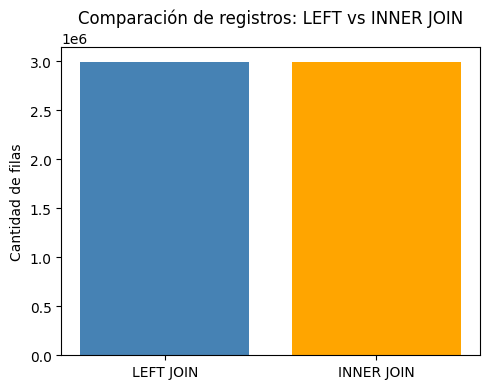

In [24]:
# LEFT JOIN
left_join = trips.merge(zones, left_on='pulocationid', right_on='locationid', how='left')

# INNER JOIN
inner_join = trips.merge(zones, left_on='pulocationid', right_on='locationid', how='inner')

# Gráfico comparativo
plt.figure(figsize=(5,4))
plt.bar(['LEFT JOIN', 'INNER JOIN'], [len(left_join), len(inner_join)], color=['steelblue','orange'])
plt.title('Comparación de registros: LEFT vs INNER JOIN')
plt.ylabel('Cantidad de filas')
plt.tight_layout()

# Guardar como PNG
plt.savefig("joins_comparacion.png", dpi=200, bbox_inches="tight")
plt.show()


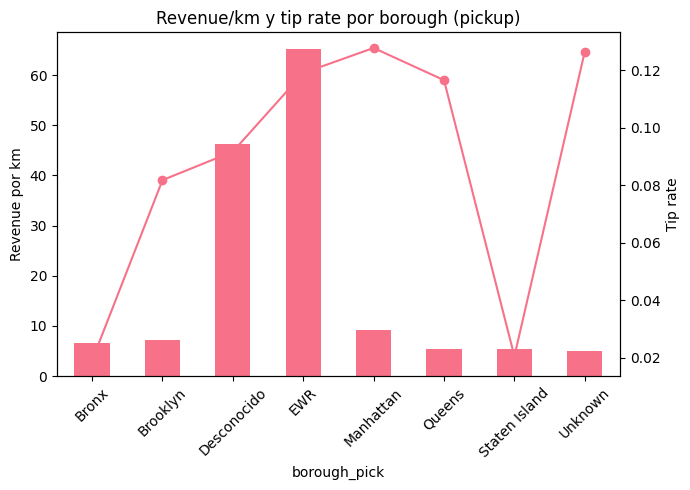

21:12:02.047 | ERROR   | prefect.server.services.telemetry - Failed to send telemetry:
Shutting down telemetry service...


In [26]:
# === Merge para agregar borough (pickup) ===
data = trips.merge(
    zones[['locationid','borough']],
    left_on='pulocationid', right_on='locationid',
    how='left'
).rename(columns={'borough':'borough_pick'})

# Asegurar numéricos
for col in ['fare_amount','tip_amount','trip_distance','total_amount']:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')

# Revenue total: usar total_amount si existe; si no, fare + tip
if 'total_amount' in data.columns:
    data['revenue_total'] = data['total_amount']
else:
    data['revenue_total'] = data['fare_amount'].fillna(0) + data.get('tip_amount', 0).fillna(0)

# === Agregación por borough ===
group = data.groupby('borough_pick', dropna=False).agg(
    viajes=('pulocationid','size'),
    revenue_total=('revenue_total','sum'),
    distancia_total=('trip_distance','sum'),
    tip_total=('tip_amount','sum')
)

group['revenue_por_km'] = group['revenue_total'] / group['distancia_total'].replace(0, np.nan)
group['tip_rate'] = group['tip_total'] / group['revenue_total'].replace(0, np.nan)

# === Gráfico: revenue/km (barras) + tip rate (línea en eje secundario) ===
fig, ax1 = plt.subplots(figsize=(7,5))
group['revenue_por_km'].plot(kind='bar', ax=ax1, rot=45)
ax1.set_ylabel('Revenue por km')
ax1.set_title('Revenue/km y tip rate por borough (pickup)')

ax2 = ax1.twinx()
group['tip_rate'].plot(kind='line', marker='o', ax=ax2)
ax2.set_ylabel('Tip rate')

plt.tight_layout()
plt.savefig("revenue_propinas.png", dpi=200, bbox_inches="tight")
plt.show()

